In [1]:
# Importing libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid', font_scale=2)

import scipy.stats as ss
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

import xgboost
from catboost import CatBoostClassifier

In [2]:
# Loading datasets

train_data = pd.read_csv('../input/spaceship-titanic/train.csv')
test_data = pd.read_csv('../input/spaceship-titanic/test.csv')

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


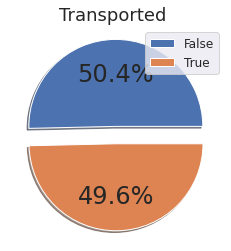

In [3]:
plt.pie(train_data.Transported.value_counts(), shadow=True, explode=[.1,.1], autopct='%.1f%%')
plt.title('Transported ', size=18)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

In [4]:
# Setting index column

train_data.set_index('PassengerId',inplace=True)
test_data.set_index('PassengerId',inplace=True)

In [5]:
# Aggregating all spending into one column

train_data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0, inplace=True)
test_data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0, inplace=True)

train_data['Total Spending'] = train_data['RoomService'] + train_data['FoodCourt'] + train_data['ShoppingMall'] + train_data['Spa'] + train_data['VRDeck']
test_data['Total Spending'] = test_data['RoomService'] + test_data['FoodCourt'] + test_data['ShoppingMall'] + test_data['Spa'] + test_data['VRDeck']

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [6]:
# Filling na values for age with the median age

train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

In [7]:
# Parsing the Cabin number

train_data[['CabinDeck', 'CabinNum', 'CabinSide']] = train_data['Cabin'].str.split('/', n=-1, expand=True)
test_data[['CabinDeck', 'CabinNum', 'CabinSide']] = test_data['Cabin'].str.split('/', n=-1, expand=True)

train_data["CabinNum"] = pd.to_numeric(train_data["CabinNum"])
test_data["CabinNum"] = pd.to_numeric(test_data["CabinNum"])

train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


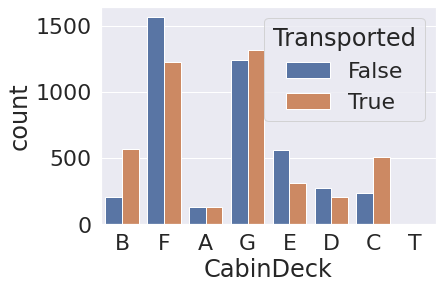

In [8]:
# Data Exploration

sns.countplot(train_data.CabinDeck,hue=train_data.Transported);

In [9]:
# Missing Values

print('TRAINING DATASET:')
print(train_data.isnull().sum())
print('\n' + 'TEST DATASET:')
print(test_data.isnull().sum())

TRAINING DATASET:
HomePlanet        201
CryoSleep         217
Destination       182
Age                 0
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
Total Spending    908
CabinDeck         199
CabinNum          199
CabinSide         199
dtype: int64

TEST DATASET:
HomePlanet         87
CryoSleep          93
Destination        92
Age                 0
VIP                93
RoomService        82
FoodCourt         106
ShoppingMall       98
Spa               101
VRDeck             80
Name               94
Total Spending    455
CabinDeck         100
CabinNum          100
CabinSide         100
dtype: int64


In [10]:
# Binning the age category to discretize its values:

# Using Cramér's V to determine the optimal number of age bins or groups between 6 and 14.
# The number of bins with the highest score works best to predict the
            # dependent variable, "Transported".

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Binning with 6-14 bins and recording scores from Cramér's V

for x in range(6, 15):
    train_data['Age Group'] = pd.cut(x = train_data['Age'], bins=x, labels=np.arange(x), right=False)
    confusion_matrix = pd.crosstab(train_data['Transported'], train_data['Age Group'])
    scpos = cramers_v(confusion_matrix.values)
    print(x, "Score = ", scpos)

6 Score =  0.11613664772898395
7 Score =  0.12051127565636346
8 Score =  0.12838037838517294
9 Score =  0.13338128406140706
10 Score =  0.13245674946505892
11 Score =  0.12860440377704135
12 Score =  0.13472967188104998
13 Score =  0.13894716937925056
14 Score =  0.13695853791257895


In [11]:
# The optimal number of bins is 13

train_data['Age Group'] = pd.cut(x = train_data['Age'], bins=13, labels=np.arange(13), right=False)
test_data['Age Group'] = pd.cut(x = test_data['Age'], bins=13, labels=np.arange(13), right=False)

In [12]:
# Dropping the 'Age' column

train_data.drop(['Age'],axis=1, inplace=True)
test_data.drop(['Age'],axis=1, inplace=True)

In [13]:
train_data['Age Group'] = pd.to_numeric(train_data['Age Group'])
test_data['Age Group'] = pd.to_numeric(test_data['Age Group'])

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8492 non-null   object 
 1   CryoSleep       8476 non-null   object 
 2   Destination     8511 non-null   object 
 3   VIP             8490 non-null   object 
 4   RoomService     8512 non-null   float64
 5   FoodCourt       8510 non-null   float64
 6   ShoppingMall    8485 non-null   float64
 7   Spa             8510 non-null   float64
 8   VRDeck          8505 non-null   float64
 9   Name            8493 non-null   object 
 10  Transported     8693 non-null   bool   
 11  Total Spending  7785 non-null   float64
 12  CabinDeck       8494 non-null   object 
 13  CabinNum        8494 non-null   float64
 14  CabinSide       8494 non-null   object 
 15  Age Group       8693 non-null   int64  
dtypes: bool(1), float64(7), int64(1), object(7)
memory usage: 1.3+ MB


In [15]:
# It would be wrong to assume filling in null values with the mean or median for these categories
# To avoid skewing the data, the rows with null values are dropped

train_data.dropna(subset=['CabinNum'], inplace=True)
test_data.dropna(subset=['CabinNum'], inplace=True)

In [16]:
# Label Encoding

categorical_cols= ['HomePlanet','CryoSleep','Destination','VIP','CabinDeck','CabinSide']
for i in categorical_cols:
    le=LabelEncoder()
    arr=np.concatenate((train_data[i], test_data[i])).astype(str)
    le.fit(arr)
    train_data[i]=le.transform(train_data[i].astype(str))
    test_data[i]=le.transform(test_data[i].astype(str))

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8494 entries, 0001_01 to 9280_02
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8494 non-null   int64  
 1   CryoSleep       8494 non-null   int64  
 2   Destination     8494 non-null   int64  
 3   VIP             8494 non-null   int64  
 4   RoomService     8317 non-null   float64
 5   FoodCourt       8316 non-null   float64
 6   ShoppingMall    8288 non-null   float64
 7   Spa             8313 non-null   float64
 8   VRDeck          8310 non-null   float64
 9   Name            8296 non-null   object 
 10  Transported     8494 non-null   bool   
 11  Total Spending  7603 non-null   float64
 12  CabinDeck       8494 non-null   int64  
 13  CabinNum        8494 non-null   float64
 14  CabinSide       8494 non-null   int64  
 15  Age Group       8494 non-null   int64  
dtypes: bool(1), float64(7), int64(7), object(1)
memory usage: 1.0+ MB


In [18]:
# Dropping the 'Name' column

train_data.drop(['Name'],axis=1, inplace=True)
test_data.drop(['Name'],axis=1, inplace=True)

train_data.describe(include='all')

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total Spending,CabinDeck,CabinNum,CabinSide,Age Group
count,8494.000000,8494.000000,8494.000000,8494.000000,8317.000000,8316.000000,8288.000000,8313.000000,8310.000000,8494,7603.000000,8494.000000,8494.000000,8494.000000,8494.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4278,NaN,NaN,NaN,NaN,NaN
mean,0.718036,0.397104,1.517306,0.069108,221.954671,457.992665,174.700531,306.623120,306.132371,NaN,1480.246876,4.305392,600.367671,0.504827,4.238404
std,0.863571,0.537488,0.838899,0.332762,640.734593,1616.551099,608.668091,1119.076668,1148.895082,NaN,2830.513700,1.778233,511.867226,0.500006,2.373175
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,3.000000,167.250000,0.000000,3.000000
50%,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,738.000000,5.000000,427.000000,1.000000,4.000000
75%,1.000000,1.000000,2.000000,0.000000,48.000000,78.250000,28.000000,59.000000,46.750000,NaN,1486.000000,6.000000,999.000000,1.000000,6.000000


In [19]:
train_data.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total Spending,CabinDeck,CabinNum,CabinSide,Age Group
PassengerId,,,,,,,,,,,,,,,
0001_01,1,0,2,0,0.0,0.0,0.0,0.0,0.0,False,0.0,1,0.0,0,6
0002_01,0,0,2,0,109.0,9.0,25.0,549.0,44.0,True,736.0,5,0.0,1,3
0003_01,1,0,2,1,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,0,0.0,1,9
0003_02,1,0,2,0,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,0,0.0,1,5
0004_01,0,0,2,0,303.0,70.0,151.0,565.0,2.0,True,1091.0,5,1.0,1,2


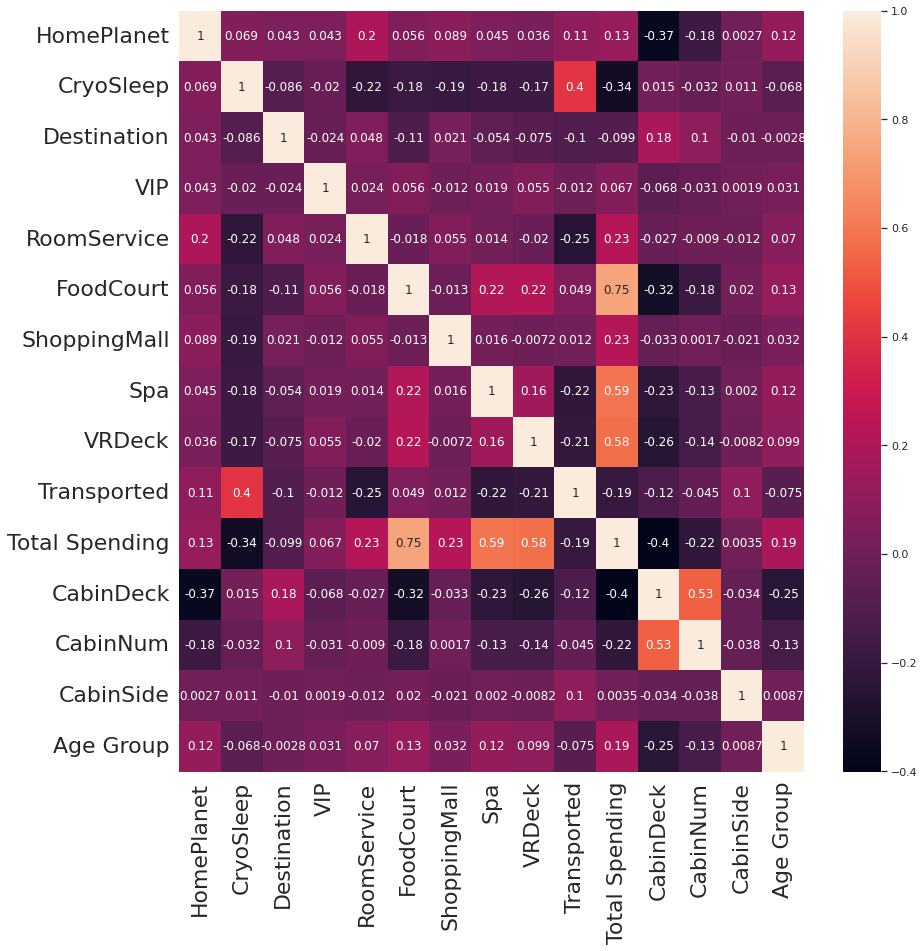

In [20]:
# Data Visualization

fig, ax = plt.subplots(figsize=(14,14)) 
sns.set(font_scale=1)
sns.heatmap(train_data.corr(), annot=True);

In [21]:
# Splitting the data into training and validation sets

train_data['Transported'] = train_data['Transported'].replace({True:1,False:0})

X = train_data.drop('Transported',axis=1)
y = train_data["Transported"]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

X_val.head(2)

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total Spending,CabinDeck,CabinNum,CabinSide,Age Group
PassengerId,,,,,,,,,,,,,,
5040_02,1,0,0,0,10.0,199.0,0.0,6216.0,101.0,6526.0,2,195.0,1,6
4569_01,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,151.0,0,4


In [22]:
# Repeated Stratified KFold Cross-validation was used to determine 
        # the best model between AdaBoost, CatBoost and XGBoost
    
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
    # scores = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs=-1)
    # scores)

# XGBoost and CatBoost were found to work best with the following hyperparameters

# For XGBoost:

model = xgboost.XGBClassifier(objective="binary:logitraw", random_state=42)
# model = xgboost.XGBClassifier(random_state=42,
                             #  n_estimators=250,learning_rate=0.68,max_depth=3)

model.fit(X_train, y_train)

[07:04:05] WARNING: ../src/learner.cc:1205: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logitraw',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [23]:
# Predicting the validation set and checking the accuracy of the predictions

pred = model.predict(X_train)
pred_y = model.predict(X_val)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_val.values,pred_y))

0.9167034584253128
0.7975279576221307


In [24]:
# Using CatBoost:

model2 = CatBoostClassifier(iterations=3000,
                         eval_metric='Accuracy',
                         verbose=0)

model2.fit(X_train,y_train)

In [25]:
# Predicting the validation set and checking the accuracy of the predictions

pred = model2.predict(X_train)
pred_y = model2.predict(X_val)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_val.values,pred_y))

0.8860927152317881
0.8287227781047675


In [26]:
# CatBoost is slower but more accurate
# Fitting the model on the entire data

model2.fit(X, y)

In [27]:
y_pred = model.predict(test_data)

output = pd.DataFrame({'Transported':y_pred.astype(bool)},index=test_data.index)

output.head()

,Transported
PassengerId,
0013_01,False
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [28]:
# Submission

output.to_csv('submission')

print("submission saved")

submission saved
